In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
%matplotlib inline

In [22]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol.to_list()
timeframe = '5y'
start_cash = 10_000

In [28]:
df=yf.download(tickers, period=timeframe)['Close']

/var/folders/pc/lwrwx3mn1jq97mrd103w8tm80000gn/T/ipykernel_50257/896026501.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download(tickers, period=timeframe)['Close']
[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=5y)')
['BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')


In [24]:
def adftest(stock1, stock2, df):
    x = df[stock1].values
    x = sm.add_constant(x)
    y = df[stock2].values

    model = sm.OLS(y,x).fit()
    intercept, slope = model.params
    residuals = y - (intercept + slope*x[:,1])
    if np.isnan(residuals).any():
        return np.nan
    result = adfuller(residuals)
    return result[0], result[1], slope, intercept

In [25]:
def test_coint (df = df):

    combination_df = pd.DataFrame(combinations(df.columns,2))
    combination_df.columns = ['Stock1','Stock2']
    combination_df['Correlation'] = combination_df.apply(lambda row: np.corrcoef(df[row['Stock1']],df[row['Stock2']])[0,1],axis=1)
    combination_df = combination_df[combination_df['Correlation'] > 0.95]
    combination_df[['adf_stat','p-value','Slope','Intercept']] = combination_df.apply(lambda row: pd.Series(adftest(row['Stock1'], row['Stock2'],df)),axis=1)
    combination_df = combination_df[combination_df['p-value'] < 0.05]
    return combination_df


In [29]:
print(test_coint())


                Stock1        Stock2  Correlation   adf_stat       p-value  \
5533        (Close, A)     (High, A)     0.996706 -14.788635  2.188639e-27   
6036        (Close, A)      (Low, A)     0.997030 -13.439680  3.867276e-25   
6539        (Close, A)     (Open, A)     0.993004 -37.256476  0.000000e+00   
8047     (Close, AAPL)  (High, AAPL)     0.998890 -10.095329  1.094686e-17   
8550     (Close, AAPL)   (Low, AAPL)     0.998858 -14.647353  3.545149e-27   
...                ...           ...          ...        ...           ...   
3011567     (Open, TT)   (Open, WAB)     0.980082  -3.487975  8.301338e-03   
3019238    (Open, URI)   (Open, VMC)     0.960454  -3.513522  7.646535e-03   
3021423    (Open, VLO)   (Open, XOM)     0.965786  -3.243155  1.761873e-02   
3024622    (Open, VST)   (Open, WMT)     0.971195  -3.502021  7.935329e-03   
3031966    (Open, WMB)   (Open, WRB)     0.959562  -3.075182  2.844517e-02   

            Slope   Intercept  
5533     1.000771    1.362344  

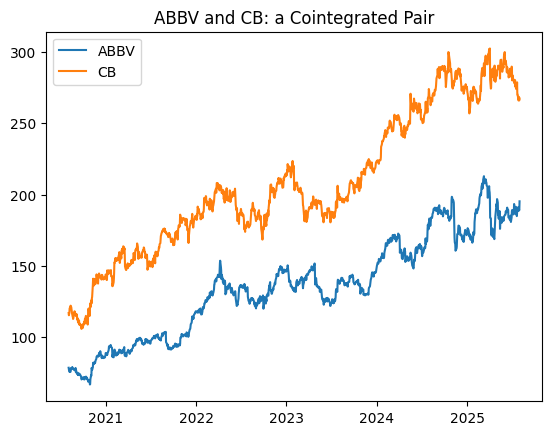

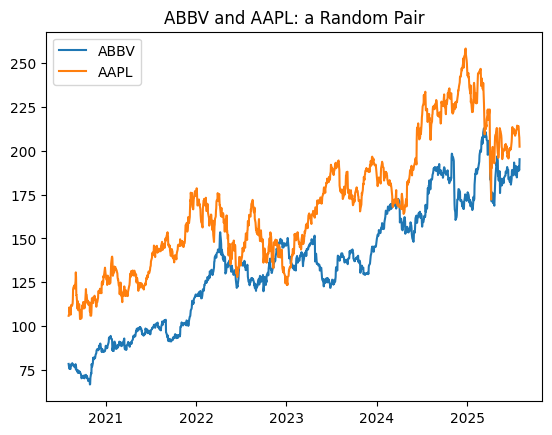

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.title('ABBV and CB: a Cointegrated Pair')
ax.plot(df['ABBV'], label = 'ABBV')
ax.plot(df['CB'], label = 'CB')
ax.legend()


fig, ax = plt.subplots()
plt.title('ABBV and AAPL: a Random Pair')
ax.plot(df['ABBV'], label = 'ABBV')
ax.plot(df['AAPL'], label = 'AAPL')
ax.legend()


plt.show()


